# Импорт библиотек

In [80]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import roc_curve,auc
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from pandas.plotting import radviz
from sklearn.model_selection import RandomizedSearchCV
import pickle

# Вспомогательные функции

In [2]:
def plot_feature_importance(importance,names,model_type):

    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + ' feature importance')
    plt.xlabel('feature importance')
    plt.ylabel('feature name')


In [3]:
def roc_curves(model):
    predictions_test = model.predict(X_test)
    fpr, tpr, thresholds = roc_curve(predictions_test,y_test)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()

In [4]:
# Loading dataset
data = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/00373/drug_consumption.data', header=None, index_col=0)
data.head()

,1,2,3,4,5,6,7,8,9,10,...,22,23,24,25,26,27,28,29,30,31
0,,,,,,,,,,,,,,,,,,,,,
1,0.49788,0.48246,-0.05921,0.96082,0.12600,0.31287,-0.57545,-0.58331,-0.91699,-0.00665,...,CL0,CL0,CL0,CL0,CL0,CL0,CL0,CL2,CL0,CL0
2,-0.07854,-0.48246,1.98437,0.96082,-0.31685,-0.67825,1.93886,1.43533,0.76096,-0.14277,...,CL4,CL0,CL2,CL0,CL2,CL3,CL0,CL4,CL0,CL0
3,0.49788,-0.48246,-0.05921,0.96082,-0.31685,-0.46725,0.80523,-0.84732,-1.62090,-1.01450,...,CL0,CL0,CL0,CL0,CL0,CL0,CL1,CL0,CL0,CL0
4,-0.95197,0.48246,1.16365,0.96082,-0.31685,-0.14882,-0.80615,-0.01928,0.59042,0.58489,...,CL0,CL0,CL2,CL0,CL0,CL0,CL0,CL2,CL0,CL0
5,0.49788,0.48246,1.98437,0.96082,-0.31685,0.73545,-1.63340,-0.45174,-0.30172,1.30612,...,CL1,CL0,CL0,CL1,CL0,CL0,CL2,CL2,CL0,CL0


In [5]:
# Checking for nan values
data.isna().sum()

1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
13    0
14    0
15    0
16    0
17    0
18    0
19    0
20    0
21    0
22    0
23    0
24    0
25    0
26    0
27    0
28    0
29    0
30    0
31    0
dtype: int64

In [6]:
data.columns

Int64Index([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
            18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31],
           dtype='int64')

In [7]:
data[1].value_counts()

-0.95197    643
-0.07854    481
 0.49788    356
 1.09449    294
 1.82213     93
 2.59171     18
Name: 1, dtype: int64

In [8]:
naming={1:'age',
       2:'gender',
       3:'education',
       4:'country',
       5:'ethnicity',
       6:'nscore',
       7:'escore',
       8:'oscore',
       9:'ascore',
       10:'cscore',
       11:'impulsive',
       12:'ss',
       13:'alcohol',
       14:'amphet',
       15:'amyl',
       16:'benzos',
       17:'caff',
       18:'cannabis',
       19:'choc',
       20:'coke',
       21:'crack',
       22:'ecstasy',
       23:'heroine',
       24:'ketamine',
       25:'legalh',
       26:'lsd',
       27:'meth',
       28:'mushrooms',
       29:'nicotine',
       30:'semer',
       31:'vsa'}

In [9]:
data = data.rename(columns = naming)

In [10]:
# overall check for columns with numerical data
data.describe()

,age,gender,education,country,ethnicity,nscore,escore,oscore,ascore,cscore,impulsive,ss
count,1885.00000,1885.000000,1885.000000,1885.000000,1885.000000,1885.000000,1885.000000,1885.000000,1885.000000,1885.000000,1885.000000,1885.000000
mean,0.03461,-0.000256,-0.003806,0.355542,-0.309577,0.000047,-0.000163,-0.000534,-0.000245,-0.000386,0.007216,-0.003292
std,0.87836,0.482588,0.950078,0.700335,0.166226,0.998106,0.997448,0.996229,0.997440,0.997523,0.954435,0.963701
min,-0.95197,-0.482460,-2.435910,-0.570090,-1.107020,-3.464360,-3.273930,-3.273930,-3.464360,-3.464360,-2.555240,-2.078480
25%,-0.95197,-0.482460,-0.611130,-0.570090,-0.316850,-0.678250,-0.695090,-0.717270,-0.606330,-0.652530,-0.711260,-0.525930
50%,-0.07854,-0.482460,-0.059210,0.960820,-0.316850,0.042570,0.003320,-0.019280,-0.017290,-0.006650,-0.217120,0.079870
75%,0.49788,0.482460,0.454680,0.960820,-0.316850,0.629670,0.637790,0.723300,0.760960,0.584890,0.529750,0.765400
max,2.59171,0.482460,1.984370,0.960820,1.907250,3.273930,3.273930,2.901610,3.464360,3.464360,2.901610,1.921730


In [11]:
substances = data.columns[-19:]
features = data.columns[:12]

In [12]:
substances

Index(['alcohol', 'amphet', 'amyl', 'benzos', 'caff', 'cannabis', 'choc',
       'coke', 'crack', 'ecstasy', 'heroine', 'ketamine', 'legalh', 'lsd',
       'meth', 'mushrooms', 'nicotine', 'semer', 'vsa'],
      dtype='object')

In [13]:
substances_law = ['alcohol','caff','choc','nicotine']
substances_illegal = ['amphet', 'amyl', 'benzos', 'cannabis',
       'coke', 'crack', 'ecstasy', 'heroine', 'ketamine', 'legalh', 'lsd',
       'meth', 'mushrooms', 'vsa']


# Визуализация данных

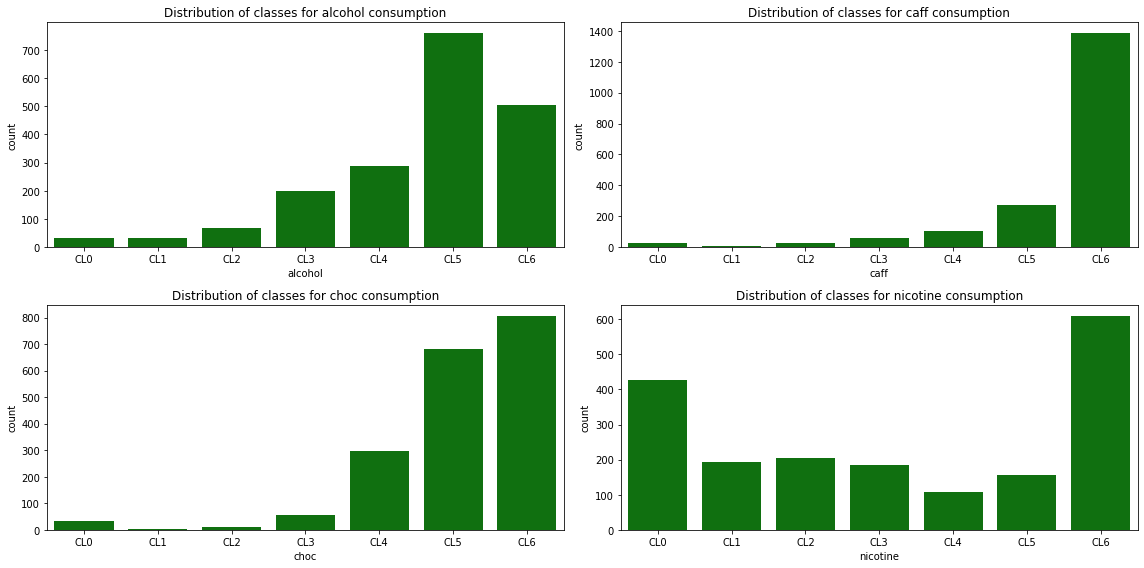

In [15]:
# Checking for classes distribution for legal substance abuse
fig, axes = plt.subplots(2,2,figsize = (16,8))
i=0
for item in substances_law:
    sns.countplot(x = data[item],data=data, ax = axes.flat[i], color = 'g',order = data[item].value_counts().index.sort_values(ascending = True))
    axes.flat[i].set_title(f'Distribution of classes for {item} consumption')
    i+=1
    
plt.tight_layout()
plt.show()

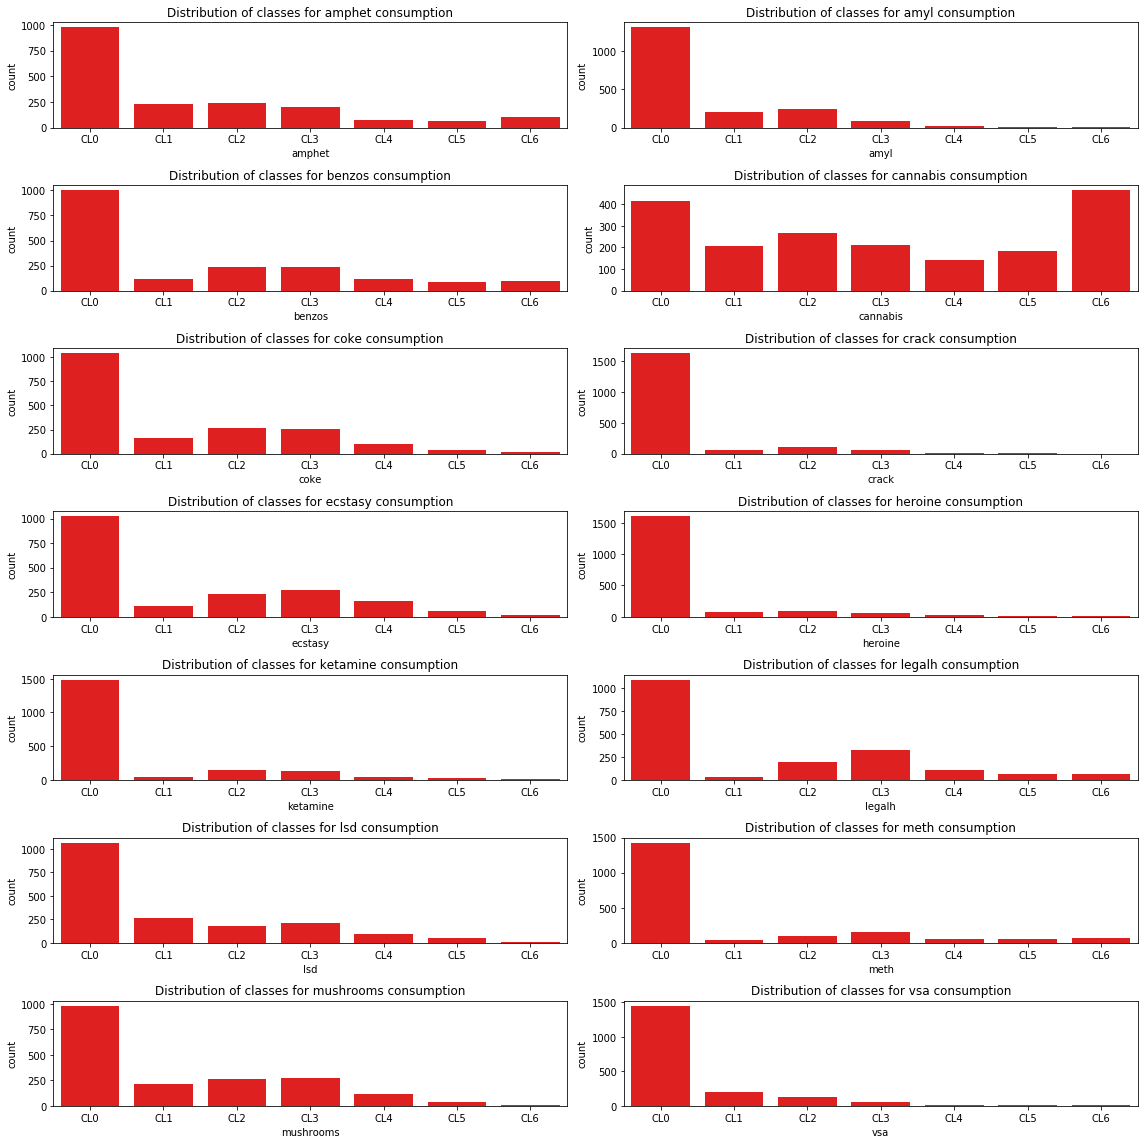

In [16]:
# Checking for classes distribution for illegal substance abuse
fig, axes = plt.subplots(7,2,figsize = (16,16))
i=0
for item in  substances_illegal:
    sns.countplot(x = data[item],data=data, ax = axes.flat[i], color = 'r',order = data[item].value_counts().index.sort_values(ascending = True))
    axes.flat[i].set_title(f'Distribution of classes for {item} consumption')
    i+=1
    
plt.tight_layout()
plt.show()

(array([0, 1, 2, 3, 4]), <a list of 5 Text xticklabel objects>)

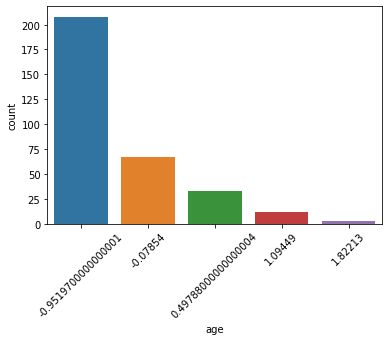

In [17]:
# Seems like there is a strange spike in legal high consumption in the last year.
# I suppose there are some college student experimenting with substances, want to check
sns.countplot(x = data[data['legalh']=='CL3']['age'], data = data)
plt.xticks(rotation = 45)

# Yes, majority of people who took legal high in the last year are from age group from 18 to 24.

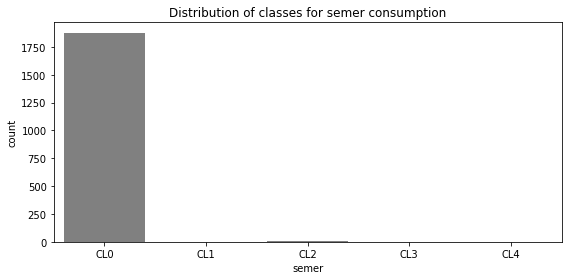

In [18]:
# Checking for classes distribution for fake substance abuse
fig, axes = plt.subplots(1,1,figsize = (8,4))
sns.countplot(x = data['semer'],data=data, color = 'grey',order = data['semer'].value_counts().index.sort_values(ascending = True))
axes.set_title(f'Distribution of classes for semer consumption')
plt.tight_layout()
plt.show()


In [19]:
# In order to convert the task into multilabel binary classification, I will transform dataset with these rules:
# Remapping values in classes for substance abuse. 1 if it was consumed in the last decade, 0 if not.

data_mbc = data.copy()
for i in substances:
    data_mbc[i] = data_mbc[i].apply(lambda x: 0 if x in ['CL0','CL6'] else 1)

In [51]:
data_mbc[substances]

,alcohol,amphet,amyl,benzos,caff,cannabis,choc,coke,crack,ecstasy,heroine,ketamine,legalh,lsd,meth,mushrooms,nicotine,semer,vsa
0,,,,,,,,,,,,,,,,,,,
1,1,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0
2,1,1,1,0,0,1,0,1,0,1,0,1,0,1,1,0,1,0,0
3,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0
4,1,0,0,1,1,1,1,1,0,0,0,1,0,0,0,0,1,0,0
5,1,1,1,0,0,1,0,0,0,1,0,0,1,0,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1884,1,0,0,0,1,1,1,0,0,0,0,0,1,1,0,0,0,0,1
1885,1,0,0,0,1,1,1,0,0,1,0,0,1,1,1,1,1,0,0
1886,1,0,1,1,0,0,0,1,0,1,0,1,0,1,0,1,0,0,0


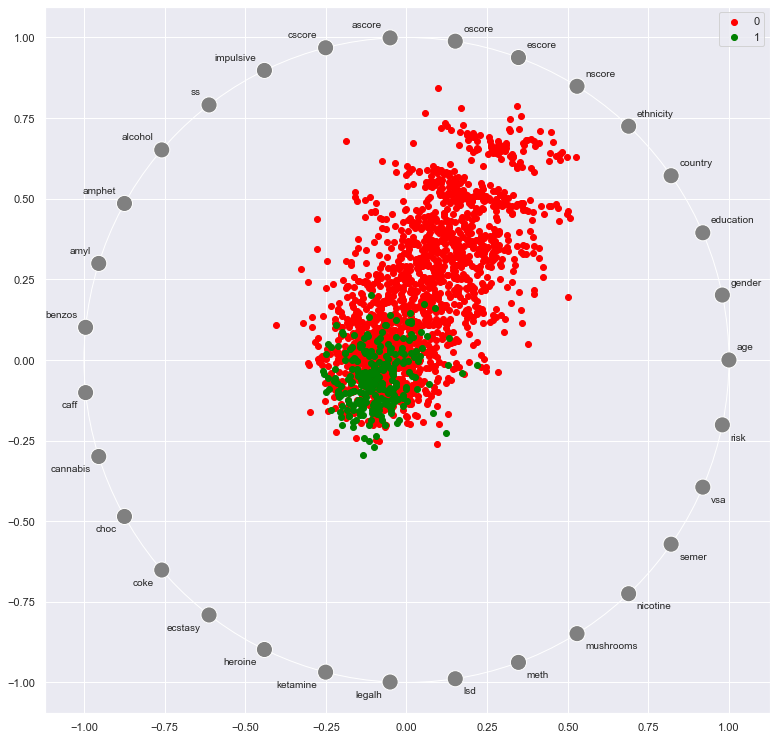

In [52]:
# Create a radial plot focusing on relationships with crack, for example
plt.figure(figsize=(13,13))
pd.plotting.radviz(data_mbc, "crack", color = ['red','green'])
plt.show()
# Surfaces can be divided

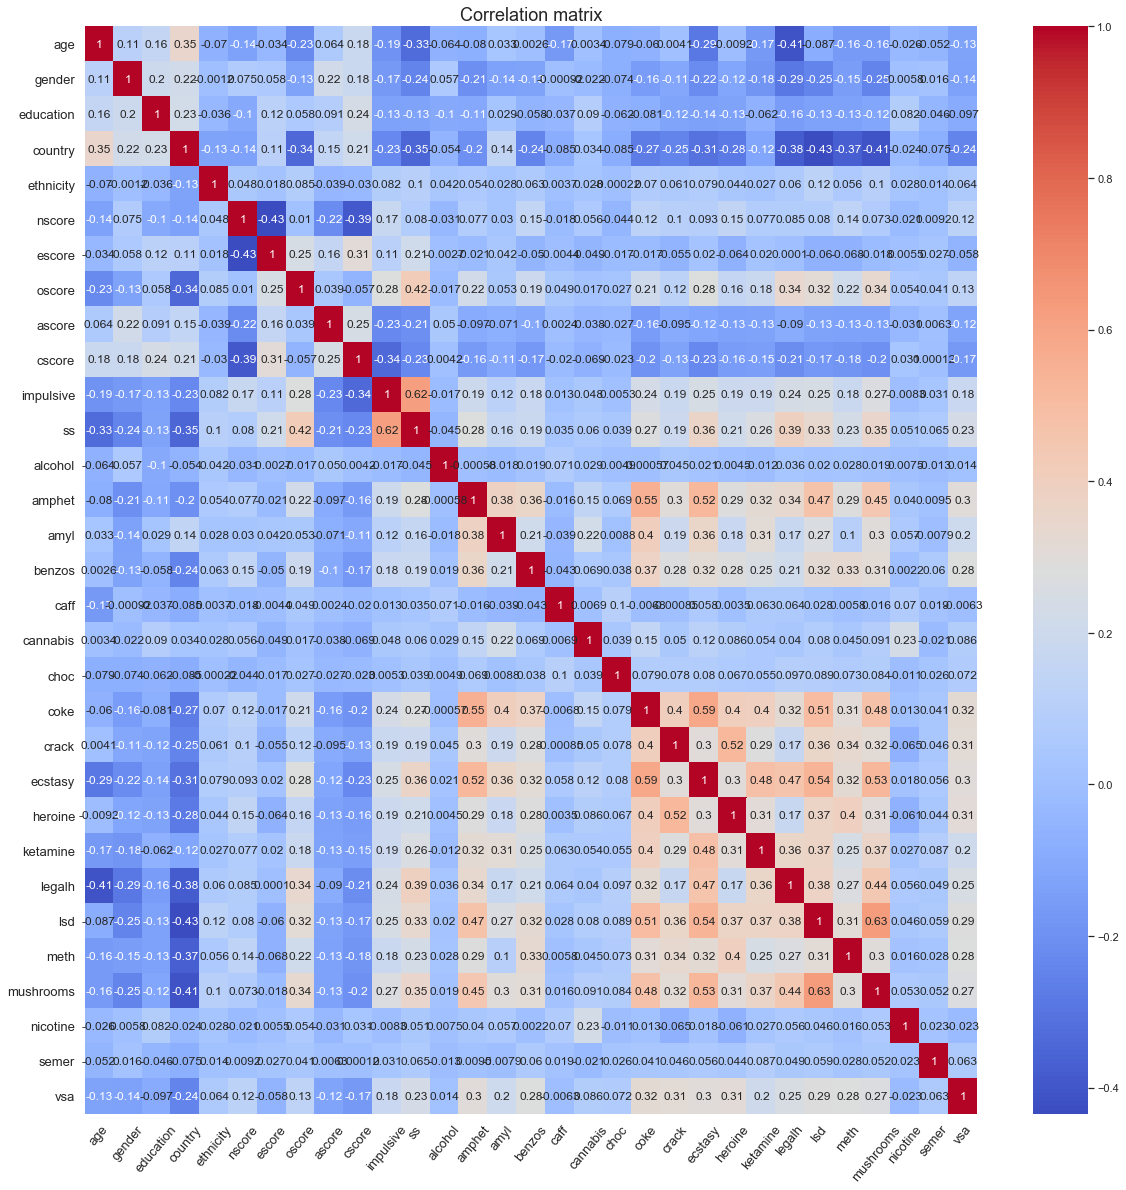

In [21]:
# Check for correlation between our features
plt.figure(figsize=(20,20))
sns.set(font_scale=1)
hm = sns.heatmap(data_mbc.corr(),cmap = 'coolwarm',annot=True)
plt.xticks(fontsize=13,rotation=50)
plt.yticks(fontsize=13)
plt.title("Correlation matrix",fontsize=18)
plt.show()
# Intresting observation - almost all illegal substances cosumptions have high positive correlation between themselves 
# one exception - cannabis.

In [22]:
# In order to summarize all data about drugs consumption and convert task to binary classification, 
# I will make new feature - risk of illegal drugs consumption. 1 if one of the illegal drugs has been consumed
# in the past 10 years, and 0 otherwise.
data_mbc['risk']=0
data_mbc.loc[data_mbc[substances_illegal].any(axis=1)==1, ['risk']]=1

In [23]:
# Dataframe for binary classification issue.
data_bc = pd.concat([data_mbc[features], data_mbc[substances_law],data_mbc['risk']], axis = 1)

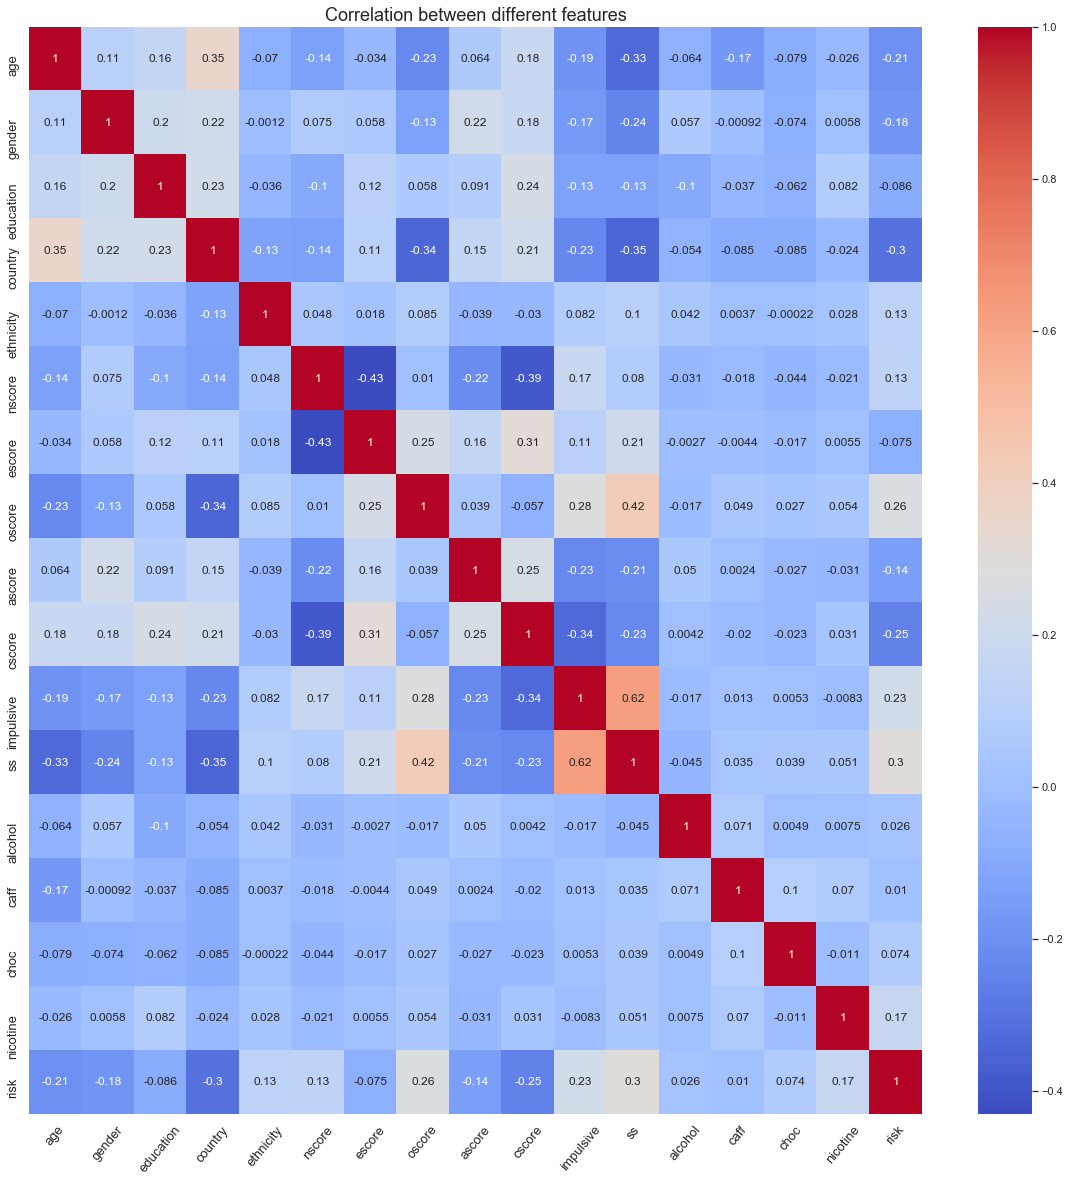

In [24]:
# Looking at correlation coefficients with regards to target feature.
# There is slight correlation with some personality measurements.
plt.figure(figsize=(20,20))

sns.set(font_scale=1)
hm = sns.heatmap(data_bc.corr(),cmap = 'coolwarm',annot=True)
plt.xticks(fontsize=13,rotation=50)
plt.yticks(fontsize=13)
plt.title("Correlation between different features",fontsize=18)
plt.show()

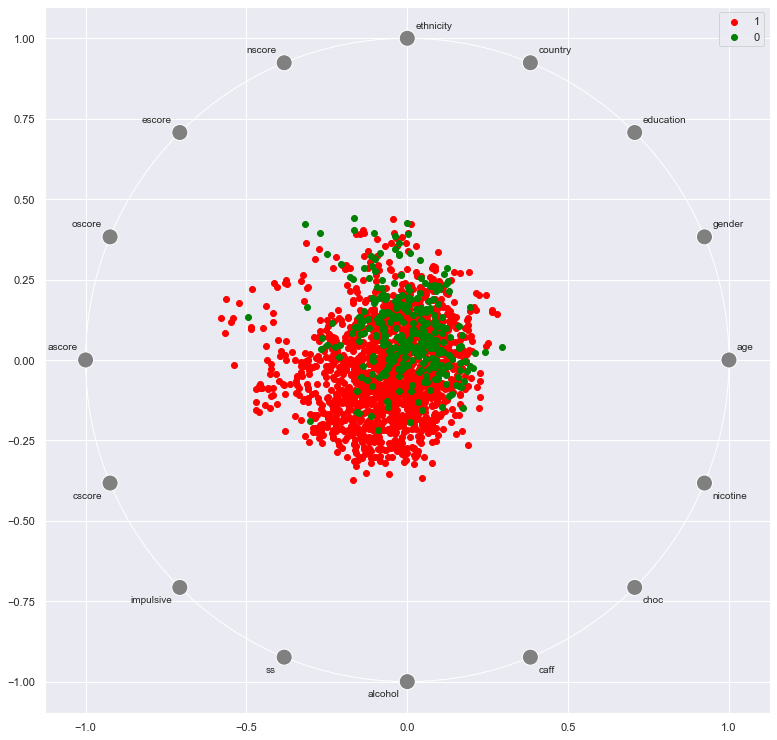

In [53]:
# Create a radial plot focusing on risk feature
plt.figure(figsize=(13,13))
pd.plotting.radviz(data_bc, "risk", color = ['red','green'])
plt.show()
# It is seen that groups can be divided somehow.

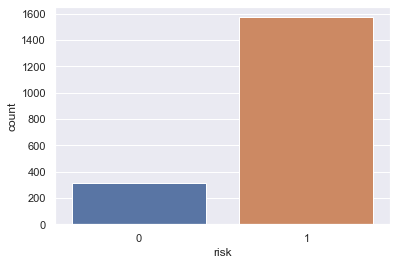

In [26]:
sns.countplot(x = data_bc['risk'], data = data_bc)
# We do not have balanced classes, it can have negative impact on our prediction.

# Построение моделей

## Подготовка данных
### Модель : K-neighbors classifier

In [28]:
X = data_bc[features]
y = data_bc['risk'].values

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [30]:
knn = KNeighborsClassifier(n_neighbors=5)  
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

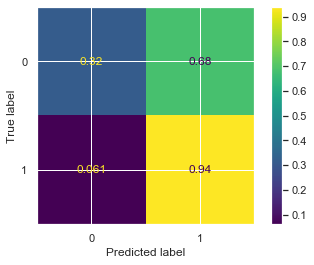

In [31]:
plot_confusion_matrix(knn,X_test,y_test,normalize = 'true')

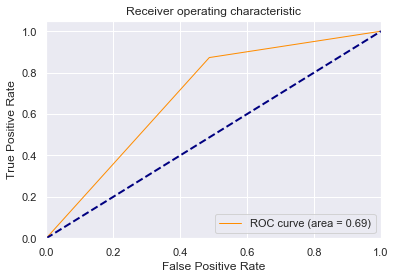

In [32]:
roc_curves(knn)

In [33]:
# Balancing data with upsampling of undersampled class. Could use SMOTE but to simplify, 
# just adding undersampled classes 4 times
data_balances = data_bc.append(data_bc[data_bc['risk']==0])
for i in range(3):
    data_balances = data_balances.append(data_bc[data_bc['risk']==0])


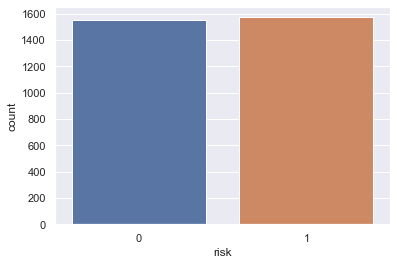

In [34]:
sns.countplot(x = data_balances['risk'], data = data_balances)

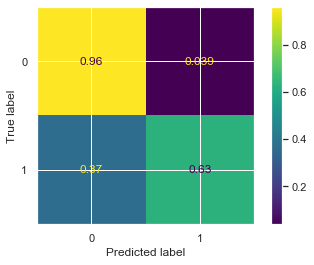

In [35]:
X = data_balances[features]
y = data_balances['risk'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
plot_confusion_matrix(knn,X_test,y_test,normalize = 'true')
# Now performance is much greater as we can more robustly predict undersampled class

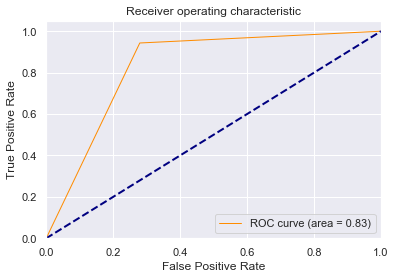

In [36]:
roc_curves(knn)
# Area under ROC curve also improved. In the future I will work with balanced dataset.

### Модель: Random forest classifier

In [38]:
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [39]:
y_pred_rf = rf.predict(X_test)

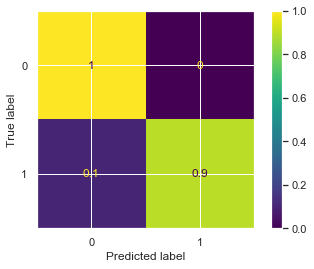

In [40]:
plot_confusion_matrix(rf,X_test,y_test,normalize = 'true')
# Better performance with comparison to knn model.

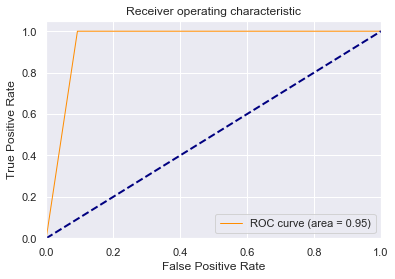

In [41]:
roc_curves(rf)
# Even better, but it can be improved with hyperparameters tuning.

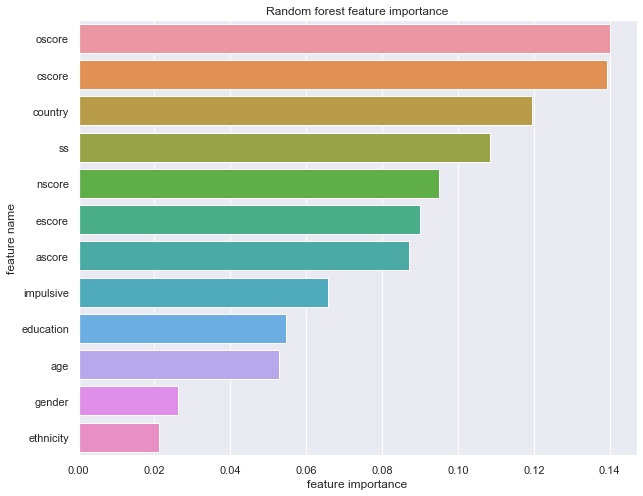

In [42]:
# Checking important features most important feature are linked with personality traits.
plot_feature_importance(rf.feature_importances_,X_train.columns,'Random forest')
# As was hypothesized - most important features for risk of substance abuse are personaity traits such as
# opennes to new experiense and conscientiousness.

### Модель: Catboost classifier

In [44]:
cbst = CatBoostClassifier(random_state = 42)

In [45]:
cbst.fit(X_train, y_train)

Learning rate set to 0.015243
0:	learn: 0.6858987	total: 167ms	remaining: 2m 46s
1:	learn: 0.6769114	total: 170ms	remaining: 1m 24s
2:	learn: 0.6690212	total: 177ms	remaining: 58.7s
3:	learn: 0.6632118	total: 179ms	remaining: 44.5s
4:	learn: 0.6573573	total: 181ms	remaining: 36s
5:	learn: 0.6508632	total: 183ms	remaining: 30.2s
6:	learn: 0.6437212	total: 184ms	remaining: 26.1s
7:	learn: 0.6388840	total: 186ms	remaining: 23.1s
8:	learn: 0.6333001	total: 188ms	remaining: 20.7s
9:	learn: 0.6276939	total: 190ms	remaining: 18.8s
10:	learn: 0.6222037	total: 192ms	remaining: 17.2s
11:	learn: 0.6178741	total: 194ms	remaining: 15.9s
12:	learn: 0.6125321	total: 195ms	remaining: 14.8s
13:	learn: 0.6075910	total: 198ms	remaining: 13.9s
14:	learn: 0.6031540	total: 200ms	remaining: 13.1s
15:	learn: 0.5982472	total: 201ms	remaining: 12.4s
16:	learn: 0.5939099	total: 204ms	remaining: 11.8s
17:	learn: 0.5891939	total: 206ms	remaining: 11.2s
18:	learn: 0.5842071	total: 207ms	remaining: 10.7s
19:	learn: 

189:	learn: 0.3660927	total: 526ms	remaining: 2.24s
190:	learn: 0.3657188	total: 528ms	remaining: 2.24s
191:	learn: 0.3652224	total: 530ms	remaining: 2.23s
192:	learn: 0.3648937	total: 532ms	remaining: 2.22s
193:	learn: 0.3644197	total: 534ms	remaining: 2.22s
194:	learn: 0.3635092	total: 536ms	remaining: 2.21s
195:	learn: 0.3628391	total: 538ms	remaining: 2.21s
196:	learn: 0.3623335	total: 540ms	remaining: 2.2s
197:	learn: 0.3618878	total: 542ms	remaining: 2.19s
198:	learn: 0.3610848	total: 544ms	remaining: 2.19s
199:	learn: 0.3607510	total: 546ms	remaining: 2.18s
200:	learn: 0.3602505	total: 547ms	remaining: 2.17s
201:	learn: 0.3596906	total: 549ms	remaining: 2.17s
202:	learn: 0.3594124	total: 551ms	remaining: 2.16s
203:	learn: 0.3592043	total: 553ms	remaining: 2.16s
204:	learn: 0.3585980	total: 555ms	remaining: 2.15s
205:	learn: 0.3581630	total: 557ms	remaining: 2.15s
206:	learn: 0.3579061	total: 559ms	remaining: 2.14s
207:	learn: 0.3575810	total: 561ms	remaining: 2.13s
208:	learn: 0

374:	learn: 0.2977825	total: 852ms	remaining: 1.42s
375:	learn: 0.2974114	total: 854ms	remaining: 1.42s
376:	learn: 0.2969508	total: 856ms	remaining: 1.41s
377:	learn: 0.2967960	total: 858ms	remaining: 1.41s
378:	learn: 0.2964755	total: 859ms	remaining: 1.41s
379:	learn: 0.2963285	total: 861ms	remaining: 1.4s
380:	learn: 0.2959823	total: 863ms	remaining: 1.4s
381:	learn: 0.2958723	total: 864ms	remaining: 1.4s
382:	learn: 0.2954805	total: 866ms	remaining: 1.4s
383:	learn: 0.2950558	total: 868ms	remaining: 1.39s
384:	learn: 0.2949224	total: 869ms	remaining: 1.39s
385:	learn: 0.2946784	total: 871ms	remaining: 1.39s
386:	learn: 0.2943939	total: 873ms	remaining: 1.38s
387:	learn: 0.2941170	total: 875ms	remaining: 1.38s
388:	learn: 0.2938191	total: 876ms	remaining: 1.38s
389:	learn: 0.2935836	total: 878ms	remaining: 1.37s
390:	learn: 0.2930915	total: 880ms	remaining: 1.37s
391:	learn: 0.2929266	total: 881ms	remaining: 1.37s
392:	learn: 0.2925598	total: 883ms	remaining: 1.36s
393:	learn: 0.29

567:	learn: 0.2445553	total: 1.19s	remaining: 902ms
568:	learn: 0.2442154	total: 1.19s	remaining: 899ms
569:	learn: 0.2439146	total: 1.19s	remaining: 897ms
570:	learn: 0.2436116	total: 1.19s	remaining: 895ms
571:	learn: 0.2432714	total: 1.19s	remaining: 892ms
572:	learn: 0.2430178	total: 1.19s	remaining: 890ms
573:	learn: 0.2427836	total: 1.2s	remaining: 888ms
574:	learn: 0.2424983	total: 1.2s	remaining: 885ms
575:	learn: 0.2422830	total: 1.2s	remaining: 883ms
576:	learn: 0.2419525	total: 1.2s	remaining: 881ms
577:	learn: 0.2415739	total: 1.2s	remaining: 878ms
578:	learn: 0.2413885	total: 1.2s	remaining: 876ms
579:	learn: 0.2408854	total: 1.21s	remaining: 874ms
580:	learn: 0.2406336	total: 1.21s	remaining: 871ms
581:	learn: 0.2401552	total: 1.21s	remaining: 869ms
582:	learn: 0.2397941	total: 1.21s	remaining: 867ms
583:	learn: 0.2393502	total: 1.21s	remaining: 864ms
584:	learn: 0.2390319	total: 1.21s	remaining: 862ms
585:	learn: 0.2389330	total: 1.22s	remaining: 859ms
586:	learn: 0.2386

752:	learn: 0.1965995	total: 1.51s	remaining: 495ms
753:	learn: 0.1961742	total: 1.51s	remaining: 493ms
754:	learn: 0.1959527	total: 1.51s	remaining: 491ms
755:	learn: 0.1957355	total: 1.51s	remaining: 489ms
756:	learn: 0.1953522	total: 1.52s	remaining: 487ms
757:	learn: 0.1950817	total: 1.52s	remaining: 485ms
758:	learn: 0.1947105	total: 1.52s	remaining: 483ms
759:	learn: 0.1945105	total: 1.52s	remaining: 481ms
760:	learn: 0.1942891	total: 1.52s	remaining: 478ms
761:	learn: 0.1942696	total: 1.52s	remaining: 476ms
762:	learn: 0.1939320	total: 1.53s	remaining: 474ms
763:	learn: 0.1939289	total: 1.53s	remaining: 472ms
764:	learn: 0.1938849	total: 1.53s	remaining: 470ms
765:	learn: 0.1937639	total: 1.53s	remaining: 468ms
766:	learn: 0.1935244	total: 1.53s	remaining: 466ms
767:	learn: 0.1933112	total: 1.53s	remaining: 464ms
768:	learn: 0.1931415	total: 1.54s	remaining: 462ms
769:	learn: 0.1931207	total: 1.54s	remaining: 460ms
770:	learn: 0.1928937	total: 1.54s	remaining: 458ms
771:	learn: 

927:	learn: 0.1632703	total: 1.84s	remaining: 143ms
928:	learn: 0.1631444	total: 1.84s	remaining: 141ms
929:	learn: 0.1630780	total: 1.84s	remaining: 139ms
930:	learn: 0.1628228	total: 1.84s	remaining: 137ms
931:	learn: 0.1626224	total: 1.85s	remaining: 135ms
932:	learn: 0.1626031	total: 1.85s	remaining: 133ms
933:	learn: 0.1624315	total: 1.86s	remaining: 132ms
934:	learn: 0.1621961	total: 1.87s	remaining: 130ms
935:	learn: 0.1619731	total: 1.87s	remaining: 128ms
936:	learn: 0.1618086	total: 1.87s	remaining: 126ms
937:	learn: 0.1617900	total: 1.87s	remaining: 124ms
938:	learn: 0.1616816	total: 1.87s	remaining: 122ms
939:	learn: 0.1616775	total: 1.88s	remaining: 120ms
940:	learn: 0.1614633	total: 1.88s	remaining: 118ms
941:	learn: 0.1612476	total: 1.88s	remaining: 116ms
942:	learn: 0.1610433	total: 1.88s	remaining: 114ms
943:	learn: 0.1609181	total: 1.88s	remaining: 112ms
944:	learn: 0.1607803	total: 1.89s	remaining: 110ms
945:	learn: 0.1605348	total: 1.89s	remaining: 108ms
946:	learn: 

In [46]:
preds_class = cbst.predict(X_test)

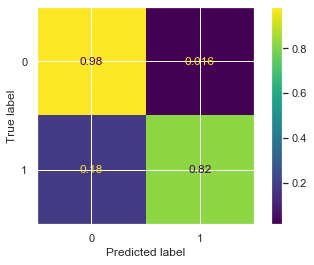

In [47]:
plot_confusion_matrix(cbst,X_test,y_test,normalize = 'true')

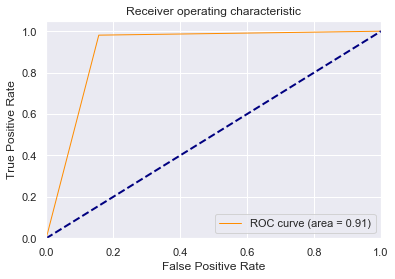

In [48]:
roc_curves(cbst)
# Random forest has better performance with this metric.

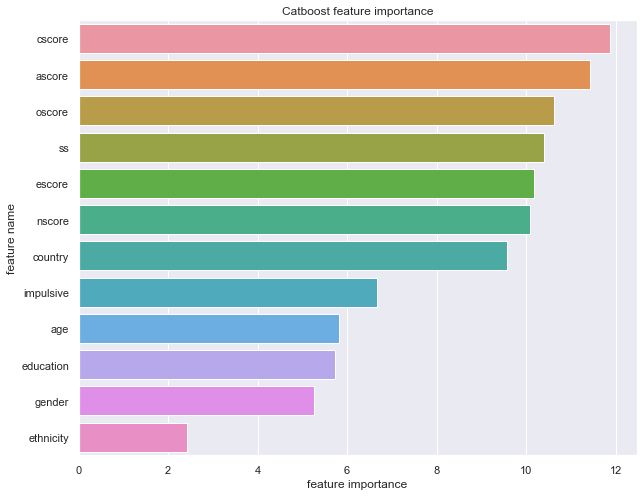

In [57]:
plot_feature_importance(cbst.feature_importances_,X_train.columns,'Catboost')
# Catboost slightly shifts top 3 parameters and adds agreeableness on the 2nd place. Couldn't disagree.

# Настройка гиперпараметров для модели random forest


In [64]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 21)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [72]:
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, scoring = 'roc_auc',
                               cv = 3, verbose=2, random_state=42, n_jobs = -1)

In [73]:
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   14.1s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   54.4s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  1.8min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

In [74]:
rf_random.best_params_

{'n_estimators': 700,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 75,
 'bootstrap': False}

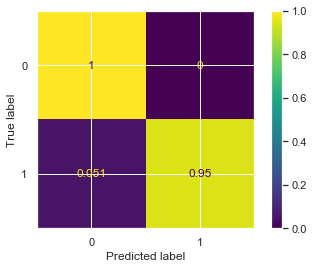

In [78]:
plot_confusion_matrix(rf_random.best_estimator_,X_test,y_test,normalize = 'true')

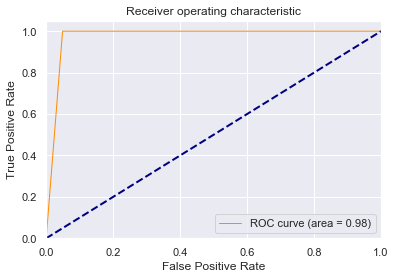

In [79]:
roc_curves(rf_random.best_estimator_)
# Pretty good

## Упаковка модели

In [81]:
pickle.dump(rf_random.best_estimator_, open('drug_risk_estimator', 'wb'))